<a href="https://colab.research.google.com/github/Bimpe1/ML-AI/blob/main/deepfake_detection%20on%20african%20facial%20images%20transfer_learning_and_evaluation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [37]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


Evaluating the custom dataset on the baseline pretrained model

In [40]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import timm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths and parameters — change this to your dataset path
data_dir = '/content/drive/MyDrive/FAGE/test_dataset'  # e.g. African test or Non-African test
batch_size = 16
num_workers = 2

# Image transforms - match training size and normalization
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
test_dataset = datasets.ImageFolder(data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Load pretrained Xception model (zero-shot baseline)
model = timm.create_model('xception', pretrained=False)
checkpoint = torch.load('/content/drive/MyDrive/FAGE/xception-43020ad28.pth')
model.load_state_dict(checkpoint)
model.reset_classifier(1)  # for binary classification
model = model.to(device)


# Evaluation function for baseline accuracy and metrics
def evaluate_baseline(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_true, y_pred)
    print(f"Baseline Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_dataset.classes))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Run evaluation
evaluate_baseline(model, test_loader)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Baseline Accuracy: 0.5532
Classification Report:
              precision    recall  f1-score   support

        fake       0.57      0.42      0.49       797
        real       0.54      0.69      0.60       792

    accuracy                           0.55      1589
   macro avg       0.56      0.55      0.55      1589
weighted avg       0.56      0.55      0.55      1589

Confusion Matrix:
[[336 461]
 [249 543]]


Finetuning the Xception model on the custom African dataset

Using device: cuda
🧪 Training classifier head first...
Epoch [1/10] | Train Acc: 80.99% | Val Acc: 83.90% | Val Loss: 0.3711
  ✅ Validation loss improved. Saving model...
Epoch [2/10] | Train Acc: 87.14% | Val Acc: 87.31% | Val Loss: 0.3199
  ✅ Validation loss improved. Saving model...
Epoch [3/10] | Train Acc: 88.33% | Val Acc: 88.58% | Val Loss: 0.3020
  ✅ Validation loss improved. Saving model...
Epoch [4/10] | Train Acc: 88.86% | Val Acc: 85.30% | Val Loss: 0.3356
  ❌ No improvement. Early stopping counter: 1/5
Epoch [5/10] | Train Acc: 88.71% | Val Acc: 87.31% | Val Loss: 0.2929
  ✅ Validation loss improved. Saving model...
Epoch [6/10] | Train Acc: 89.20% | Val Acc: 89.11% | Val Loss: 0.2786
  ✅ Validation loss improved. Saving model...
Epoch [7/10] | Train Acc: 89.39% | Val Acc: 85.24% | Val Loss: 0.3336
  ❌ No improvement. Early stopping counter: 1/5
Epoch [8/10] | Train Acc: 89.73% | Val Acc: 88.84% | Val Loss: 0.2696
  ✅ Validation loss improved. Saving model...
Epoch [9/10] 

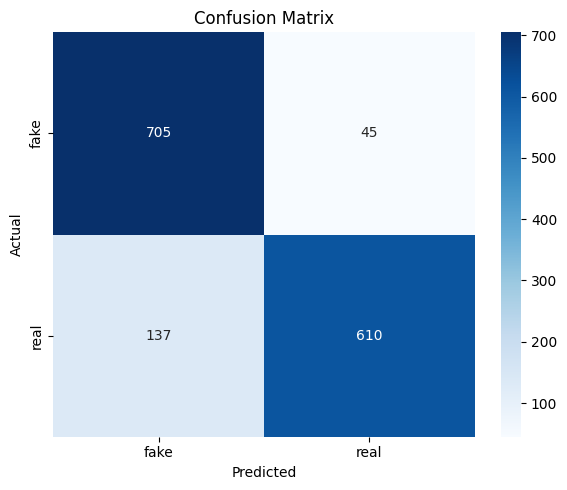

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import os
import copy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Image size for Xception
input_size = 299

# Paths (adjust accordingly)
train_dir = '/content/drive/MyDrive/FAGE/training_dataset'
val_dir = '/content/drive/MyDrive/FAGE/val_dataset'

# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((320, 320)),                      # Resize slightly larger
    transforms.RandomResizedCrop((299, 299), scale=(0.9, 1.0)),  # Crop to original size
    transforms.RandomHorizontalFlip(),                  # Natural variation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Lighting variation
    transforms.RandomRotation(5),                       # Small rotations only
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

class_names = train_dataset.classes

# Load pretrained XceptionNet
model = timm.create_model('xception', pretrained=True)
for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)  # match original xception structure
model = model.to(device)


# Train classifier head first
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping settings
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience = 5
counter = 0
num_epochs = 10

print("🧪 Training classifier head first...")
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
        print("  ✅ Validation loss improved. Saving model...")
    else:
        counter += 1
        print(f"  ❌ No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("  ⛔ Early stopping triggered.")
            break

# Load best head-trained model
model.load_state_dict(best_model_wts)

# 🔓 Unfreeze last two blocks
print("\n🔓 Unfreezing last layers for fine-tuning...")
for name, param in model.named_parameters():
    if "block14" in name or "block13" in name:
        param.requires_grad = True

# Update optimizer for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Fine-tuning loop
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
counter = 0

print("🔁 Fine-tuning with unfreezing...")
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Fine-Tune Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        counter = 0
        print("  ✅ Validation loss improved. Saving model...")
    else:
        counter += 1
        print(f"  ❌ No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("  ⛔ Early stopping triggered.")
            break

# Save final model
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "/content/drive/MyDrive/xception_finetuned_best.pth")
print("✅ Final model saved as 'xception_finetuned_best.pth'")

# 📊 Evaluation function
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n📊 Evaluation Metrics:")
    print(f"✅ Accuracy: {acc:.2f}")
    print(f"✅ F1 Score (weighted): {f1:.2f}")

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Run final evaluation
evaluate_model(model, val_loader, class_names)


Evaluating the fine-tuned model on the test dataset

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(



✅ Test Accuracy: 0.8773
              precision    recall  f1-score   support

        fake       0.83      0.94      0.89       797
        real       0.93      0.81      0.87       792

    accuracy                           0.88      1589
   macro avg       0.88      0.88      0.88      1589
weighted avg       0.88      0.88      0.88      1589



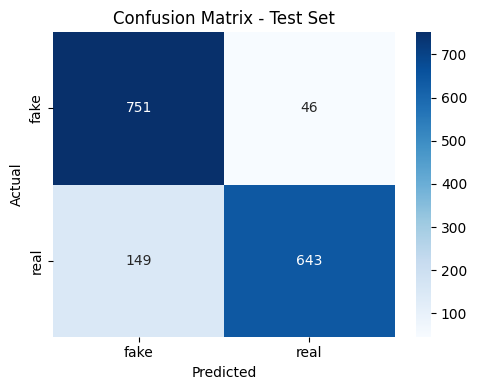

In [41]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
TEST_DIR = "/content/drive/MyDrive/FAGE/test_dataset"
MODEL_PATH = "/content/drive/MyDrive/FAGE/xception_finetuned_best.pth"
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms (same as validation) ---
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- Load Dataset ---
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Load Model ---
model = create_model('xception', pretrained=False)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# --- Run Inference ---
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Evaluate ---
class_names = test_dataset.classes  # ['real', 'fake']
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {acc:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Evaluating Model Performance Across Skin Tone Variations

In [42]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

IMAGE_DIR = '/content/drive/MyDrive/FAGE/test_dataset'
OUTPUT_CSV = '/content/drive/MyDrive/FAGE/skin_tone_labels.csv'
SKIN_TONE_THRESHOLD = 155  # Can be changed

def estimate_skin_color_from_full_image(image_rgb):
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    h, w, _ = lab.shape
    patch = lab[h//4:h*3//4, w//4:w*3//4, 0]
    mean_lightness = np.mean(patch)
    return mean_lightness

def classify_skin_tone(lightness, threshold=SKIN_TONE_THRESHOLD):
    """
    Classify skin tone based on lightness value.
    """
    return 'light' if lightness >= threshold else 'dark'

def get_label_from_path(img_path):
    """
    Assign 'real' or 'fake' based on folder name.
    """
    return os.path.basename(os.path.dirname(img_path)).lower()

# --- COLLECT ALL IMAGE PATHS ---
image_paths = []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

# --- MAIN PROCESSING LOOP ---
data = []

for img_path in tqdm(image_paths, desc="Processing images"):
    try:
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        lightness = estimate_skin_color_from_full_image(img_rgb)
        skin_tone = classify_skin_tone(lightness)
        label = get_label_from_path(img_path)

        data.append((img_path, label, skin_tone, round(lightness, 2)))
    except Exception as e:
        print(f"⚠️ Error with {img_path}: {e}")

# --- SAVE RESULTS ---
df = pd.DataFrame(data, columns=['image_path', 'label', 'skin_tone', 'lightness'])
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Done. Saved {len(df)} labeled entries to '{OUTPUT_CSV}'")


Processing images: 100%|██████████| 1589/1589 [00:10<00:00, 145.36it/s]



✅ Done. Saved 1589 labeled entries to '/content/drive/MyDrive/FAGE/skin_tone_labels.csv'


Evaluating the baseline pretrained model against the skin tone variations




In [48]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from timm import create_model
from PIL import Image
from tqdm import tqdm
import os
from sklearn.metrics import classification_report, accuracy_score

# --- CONFIG ---
CSV_PATH = '/content/drive/MyDrive/FAGE/skin_tone_labels.csv'  # From earlier step
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 299  # Xception expects 299x299
BATCH_SIZE = 32  # Set to 1 if you're doing this simply

# --- LOAD SKIN TONE CSV ---
df = pd.read_csv(CSV_PATH)

# --- LOAD PRETRAINED XCEPTION MODEL ---
model = create_model('xception', pretrained=True, num_classes=2)
model.eval()
model.to(DEVICE)

# --- IMAGE PREPROCESSING ---
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1] for Xception
])

# --- INFERENCE ---
pred_labels = []
true_labels = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['image_path']
    gt_label = 1 if row['label'] == 'fake' else 0

    try:
        image = Image.open(img_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(image_tensor)
            pred = torch.argmax(output, dim=1).item()

        pred_labels.append(pred)
        true_labels.append(gt_label)

    except Exception as e:
        print(f"⚠️ Error processing {img_path}: {e}")
        pred_labels.append(-1)
        true_labels.append(-1)

# --- FILTER OUT FAILURES ---
df['true_label'] = true_labels
df['pred_label'] = pred_labels
df = df[df['pred_label'] != -1]  # remove failed predictions

# --- METRICS BY SKIN TONE ---
for tone in ['light', 'dark']:
    subset = df[df['skin_tone'] == tone]
    y_true = subset['true_label']
    y_pred = subset['pred_label']

    print(f"\n🧪 Performance on {tone.upper()} skin tone ({len(subset)} samples):")
    print(classification_report(y_true, y_pred, target_names=['real', 'fake']))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
100%|██████████| 1589/1589 [00:22<00:00, 70.02it/s]



🧪 Performance on LIGHT skin tone (201 samples):
              precision    recall  f1-score   support

        real       0.60      0.91      0.73       117
        fake       0.58      0.17      0.26        84

    accuracy                           0.60       201
   macro avg       0.59      0.54      0.49       201
weighted avg       0.60      0.60      0.53       201

✅ Accuracy: 0.6020

🧪 Performance on DARK skin tone (1388 samples):
              precision    recall  f1-score   support

        real       0.49      0.89      0.63       675
        fake       0.50      0.11      0.17       713

    accuracy                           0.49      1388
   macro avg       0.49      0.50      0.40      1388
weighted avg       0.49      0.49      0.39      1388

✅ Accuracy: 0.4870


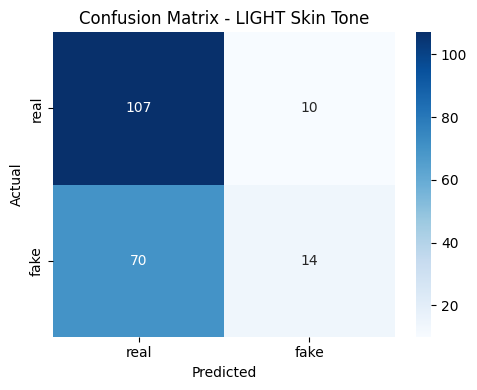

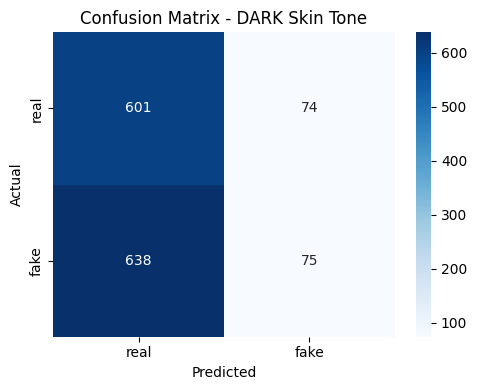

In [50]:
class_names = ['real', 'fake']

# Loop through skin tones
for tone in ['light', 'dark']:
    subset = df[df['skin_tone'] == tone]
    y_true = subset['true_label']
    y_pred = subset['pred_label']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {tone.upper()} Skin Tone")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


Evaluating the fine-tuned model against the skin tone variations


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
100%|██████████| 1589/1589 [00:35<00:00, 44.97it/s]



🧪 Performance on LIGHT skin tone (201 samples):
              precision    recall  f1-score   support

        real       0.78      0.93      0.85        84
        fake       0.94      0.81      0.87       117

    accuracy                           0.86       201
   macro avg       0.86      0.87      0.86       201
weighted avg       0.87      0.86      0.86       201

✅ Accuracy: 0.8607

🧪 Performance on DARK skin tone (1388 samples):
              precision    recall  f1-score   support

        real       0.84      0.94      0.89       713
        fake       0.93      0.81      0.87       675

    accuracy                           0.88      1388
   macro avg       0.89      0.88      0.88      1388
weighted avg       0.89      0.88      0.88      1388

✅ Accuracy: 0.8797


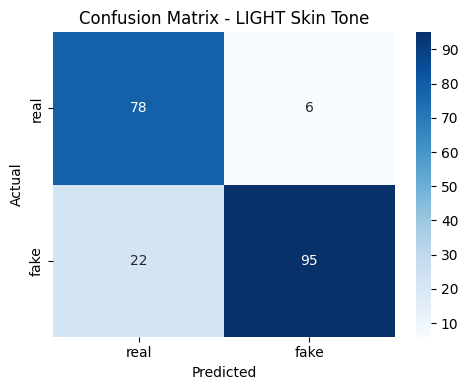

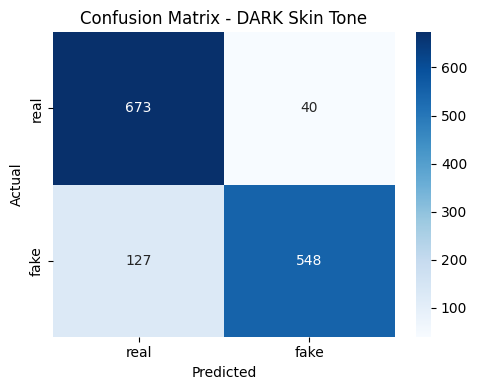

In [53]:
CSV_PATH = '/content/drive/MyDrive/FAGE/skin_tone_labels.csv'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 299  # Xception expects 299x299
BATCH_SIZE = 32  # Set to 1 if you're doing this simply
MODEL_PATH= '/content/drive/MyDrive/FAGE/xception_finetuned_best.pth'
# --- LOAD SKIN TONE CSV ---
df = pd.read_csv(CSV_PATH)

# --- LOAD PRETRAINED XCEPTION MODEL ---
model = create_model('xception', pretrained=False)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# --- IMAGE PREPROCESSING ---
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1] for Xception
])

# --- INFERENCE ---
pred_labels = []
true_labels = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['image_path']
    gt_label = 0 if row['label'] == 'fake' else 1

    try:
        image = Image.open(img_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(image_tensor)
            pred = torch.argmax(output, dim=1).item()

        pred_labels.append(pred)
        true_labels.append(gt_label)

    except Exception as e:
        print(f"⚠️ Error processing {img_path}: {e}")
        pred_labels.append(-1)
        true_labels.append(-1)

# --- FILTER OUT FAILURES ---
df['true_label'] = true_labels
df['pred_label'] = pred_labels
df = df[df['pred_label'] != -1]  # remove failed predictions

# --- METRICS BY SKIN TONE ---
for tone in ['light', 'dark']:
    subset = df[df['skin_tone'] == tone]
    y_true = subset['true_label']
    y_pred = subset['pred_label']

    print(f"\n🧪 Performance on {tone.upper()} skin tone ({len(subset)} samples):")
    print(classification_report(y_true, y_pred, target_names=['real', 'fake']))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")

class_names = ['real', 'fake']

# --- Confusion Matrix by Skin Tone ---
for tone in ['light', 'dark']:
    subset = df[df['skin_tone'] == tone]
    y_true = subset['true_label']
    y_pred = subset['pred_label']

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {tone.upper()} Skin Tone")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()